## COVID19DB PROJECT (www.covid19db.org): covid19 mortality map
This notebook demonstrates how to connect to COVID19db Postgres database and how to generate covid19 mortality map.

In [1]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()
cur.execute("""SELECT i.* FROM
                (SELECT max(date) AS date, countrycode 
                FROM epidemiology WHERE source='WRD_ECDC' AND countrycode<>''
                GROUP BY countrycode ) AS recent_data
            INNER JOIN epidemiology AS i
            ON i.date=recent_data.date 
            AND i.countrycode = recent_data.countrycode
            AND i.adm_area_1 IS NULL
            ORDER by i.dead DESC
            """)
covid19_data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

In [2]:
covid19_data[['country', 'countrycode','dead']].head()

,country,countrycode,dead
0,Sweden,SWE,NaN
1,United_States_of_America,USA,110514.0
2,United States,USA,105040.0
3,United Kingdom,GBR,40597.0
4,United_Kingdom,GBR,40542.0


In [3]:
import json
import geopandas as gpd

df = gpd.read_file('data/countries_geometries.geojson');

In [4]:
covid19_data = df.merge(
    covid19_data[['countrycode','dead']], 
    how = 'left', left_on = 'ADM0_A3', right_on = 'countrycode'
)
covid19_data.fillna({'dead':0}, inplace=True)

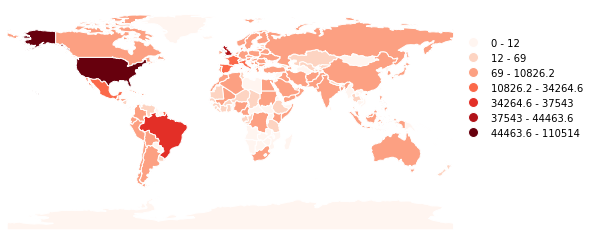

In [5]:
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc

schema = mc.Percentiles(covid19_data['dead'], pct=[30, 50, 95, 97, 98, 99, 100])
gplt.choropleth(
    covid19_data,  
    hue='dead',     
    edgecolor='white', 
    linewidth=1,
    cmap='Reds',
    scheme=schema,
    legend=True, 
    legend_kwargs={'bbox_to_anchor': (1, 0.9), 'frameon': False},
)

### Interactive map with folum:

In [6]:
import folium
import numpy as np

world_map = folium.Map(location=[11,0], tiles="cartodbpositron", zoom_start=2, max_zoom = 4, min_zoom = 2)

folium.Choropleth(
     geo_data='data/countries_geometries.geojson',
     data=covid19_data,
     columns=['countrycode', 'dead'],
     key_on='feature.properties.ADM0_A3',
     fill_color='YlOrRd', 
     fill_opacity=0.7, 
     line_opacity=0.2,
     highlight=True,
     legend_name='COVID19 mortality per country',
     nan_fill_color='black',
     nan_fill_opacity=0.4,
).add_to(world_map);


from IPython.core.display import HTML
HTML(world_map._repr_html_())